In [4]:
# This notebeook is for displaying statistics about the ood dataset split

In [5]:
# load corpus dataset
from src.data.create_corpus_dataset import create_dataset, DatasetConfig, UtteranceType, DatasetSplitType
import os
from datasets import load_from_disk
from src.data.dataset_splits import create_splits_from_corpus_dataset
from collections import defaultdict
import pandas as pd

# load dataset
dataset_folder = "../../data/processed/"
dataset_path = os.path.join(dataset_folder, "corpus_dataset_v1")

if not os.path.exists(dataset_path):
    # Beispiel zum Erstellen eines Datensatzes. Mögliche Optionen von DatasetConfig sind im DocString beschrieben.
    create_dataset(
        DatasetConfig(
            dataset_path=dataset_path,
            project_dir="../../",
            num_previous_turns=3,
            include_role=True,
            sep_token="[SEP]",
            utterance_type=UtteranceType.User,
            eval_size=0.5,
            validation_test_ratio=0.5
        )
    )

# Beispiel zum Laden des Datensatzes + collate_function des DataLoaders um dynamisch ein Subset der negative passages zu laden.
corpus_dataset = load_from_disk(dataset_path)

In [6]:
from ethikchat_argtoolkit.Dialogue.discussion_szenario import \
    DiscussionSzenario  # Create an Out-of-Distribution (Simple) split
test_scenario = DiscussionSzenario.MEDAI
ood_split = create_splits_from_corpus_dataset(corpus_dataset,
                                                      DatasetSplitType.OutOfDistributionHard,
                                                      save_folder=dataset_folder,
                                                      dataset_save_name=f"dataset_split_by_scenario_{test_scenario}",
                                                      test_scenario=test_scenario)
ood_split["train"]["queries"]


Dataset already exists at ../../data/processed/dataset_split_by_scenario_MEDAI. Loading it.


/home/christian/PycharmProjects/ethikchat-experiment-argument-classification/src/data/dataset_splits.py:109: UserWarning: Overlapping texts between train and test (but no overlapping query ids, so theses are not the same queries): 1
Example texts: ['KI ist guenstiger ']
  warnings.warn(


Dataset({
    features: ['id', 'text', 'labels', 'discussion_scenario'],
    num_rows: 1068
})

In [10]:
# Count labels per scenario and split
label_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

for split in ["train", "validation", "test"]:
    for query in ood_split[split]["queries"]:
        scenario = query["discussion_scenario"]
        for label in query["labels"]:
            label_counts[split][scenario][label] += 1

# Build dataframe
records = []
for split, split_dict in label_counts.items():
    for scenario, labels in split_dict.items():
        for label, count in labels.items():
            records.append({
                "scenario": scenario,
                "label": label,
                "split": split,
                "count": count
            })

dataframe = pd.DataFrame(records)
dataframe

,scenario,label,split,count
0,JURAI,Z.P1-1,train,34
1,JURAI,Z.K4,train,12
2,JURAI,Z.K6-1-1,train,11
3,JURAI,Z.P4-1,train,19
4,JURAI,Z.K5,train,4
...,...,...,...,...
306,MEDAI,Z.GP74-1,test,1
307,MEDAI,Z.GP21-1,test,1
308,MEDAI,Z.K1-2,test,1
309,MEDAI,FAQ.1-1,test,1


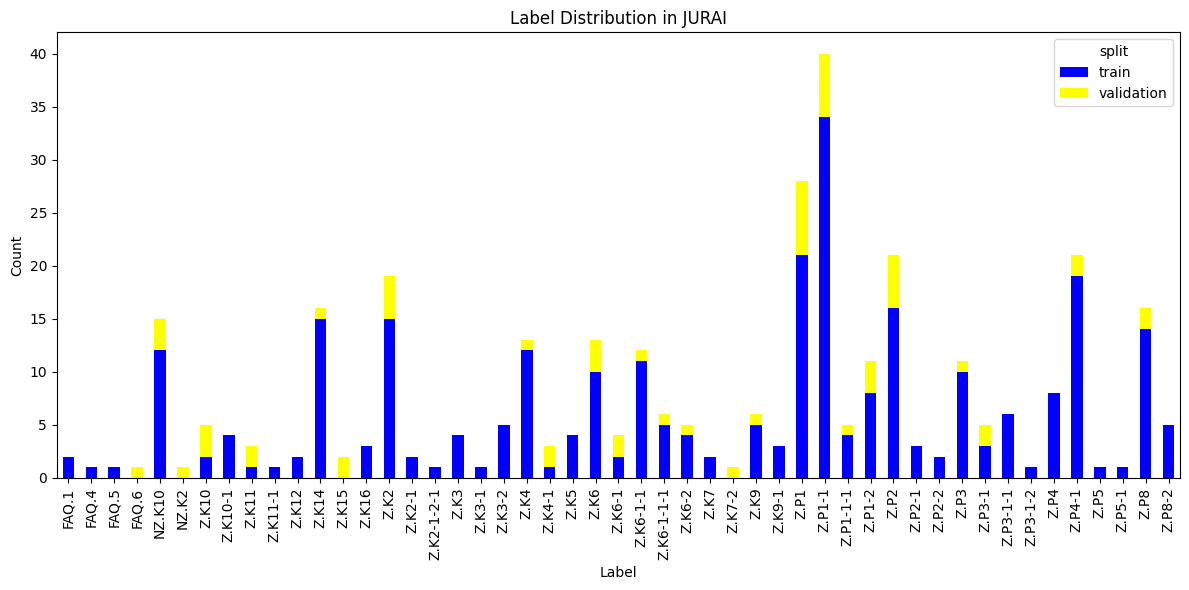

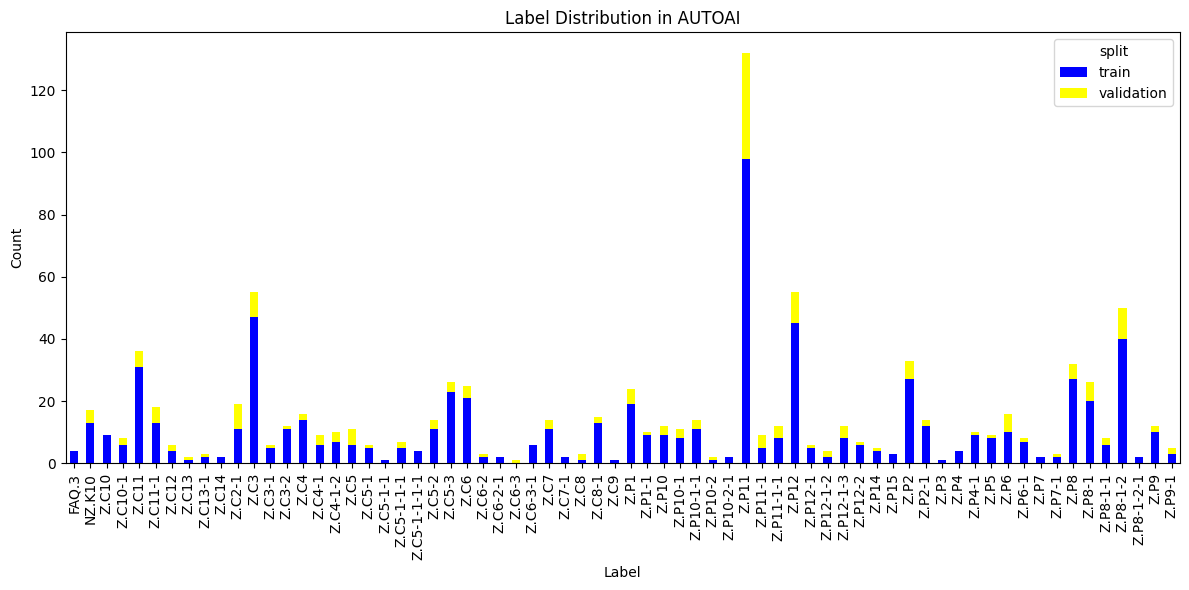

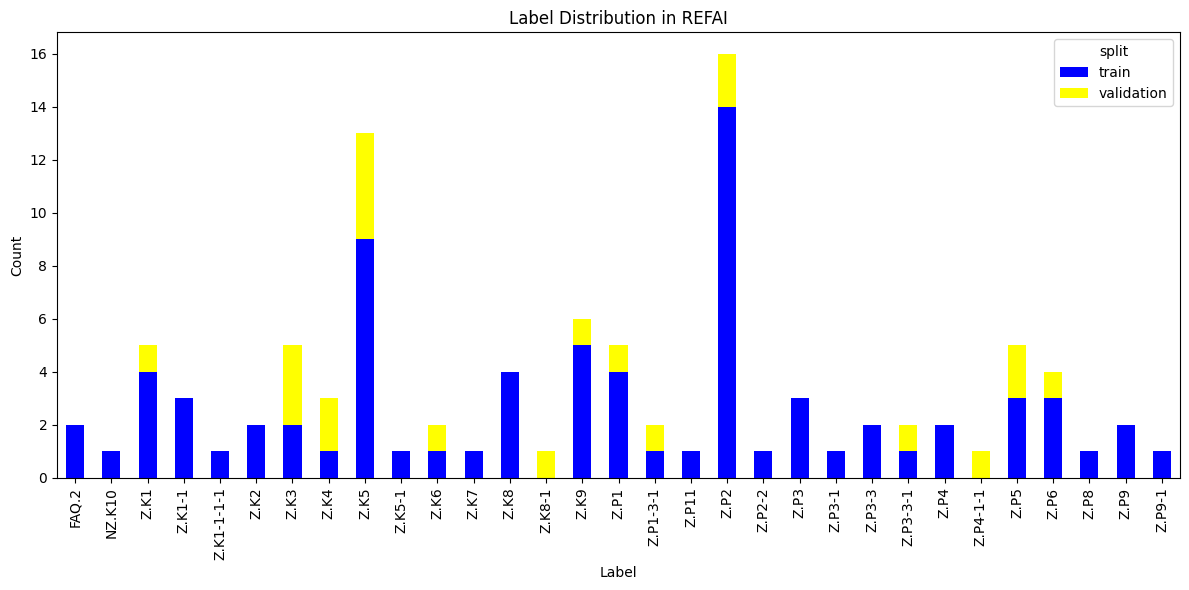

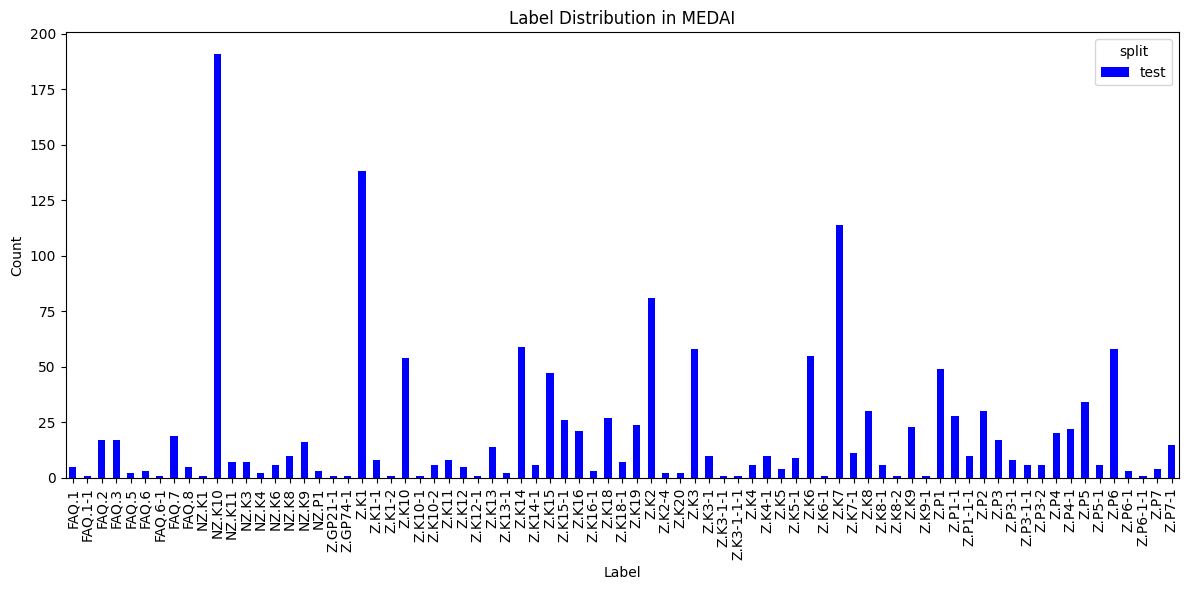

In [8]:
import matplotlib.pyplot as plt

# # Plot stacked bar chart per scenario
scenarios = dataframe["scenario"].unique()
for scenario in scenarios:
    df_scenario = dataframe[dataframe["scenario"] == scenario]
    pivot_df = df_scenario.pivot(index="label", columns="split", values="count").fillna(0)
    pivot_df.plot(kind="bar", stacked=True, color=["blue", "yellow", "red"], figsize=(12, 6))
    plt.title(f"Label Distribution in {scenario}")
    plt.ylabel("Count")
    plt.xlabel("Label")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [9]:
def check_label_distribution(df):
    """
    Checks that any (scenario, label) pair found in 'validation' or 'test'
    also exists in 'train'. If not, prints out the faulty scenario-label pairs.
    Otherwise, confirms that the distribution is valid.
    """
    # Get all (scenario, label) pairs that appear in train (count > 0)
    train_pairs = df[(df["split"] == "train") & (df["count"] > 0)][["scenario", "label"]]
    dis_allowed_pairs = set(zip(train_pairs["scenario"], train_pairs["label"]))

    # Find all pairs in test that have count > 0
    non_train = df[df["split"].isin(["test"]) & (df["count"] > 0)].copy()

    # Mark which of these are allowed
    non_train["is_allowed"] = non_train.apply(
        lambda row: (row["scenario"], row["label"]) not in dis_allowed_pairs, axis=1
    )

    # Collect the ones that are not allowed
    faulty = non_train[~non_train["is_allowed"]]

    if len(faulty) > 0:
        print("Found scenario/label pairs in test that do appear in train:")
        print(faulty[["scenario", "label", "split", "count"]])
    else:
        print("All scenario/label pairs in test are valid (they don't appear in train).")


check_label_distribution(dataframe)

All scenario/label pairs in test are valid (they appear in train).
